load model

In [97]:
import torch
from lenet import LeNet
from linformer import Linformer
from vit_pytorch.efficient import ViT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using '+str(device)+"!")

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

vit = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)


lenet = LeNet().to(device)

Using cuda!


In [98]:
import json
with open("stat.json", "r") as f:
    loaded_stat = json.load(f)

# print(loaded_stat)

train_loss_vit = loaded_stat['train_loss_vit']
train_acc_vit = loaded_stat['train_acc_vit']
test_loss_vit = loaded_stat['test_loss_vit']
test_acc_vit = loaded_stat['test_acc_vit']

train_loss_lenet = loaded_stat['train_loss_lenet']
train_acc_lenet = loaded_stat['train_acc_lenet']
test_loss_lenet = loaded_stat['test_loss_lenet']
test_acc_lenet = loaded_stat['test_acc_lenet']

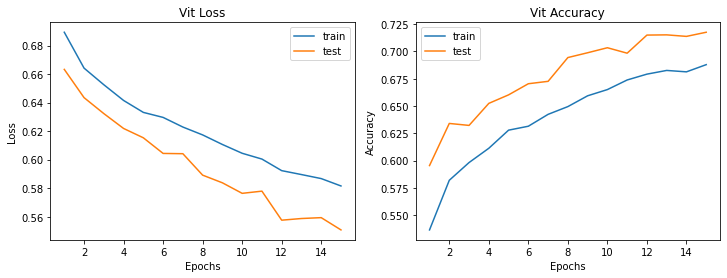

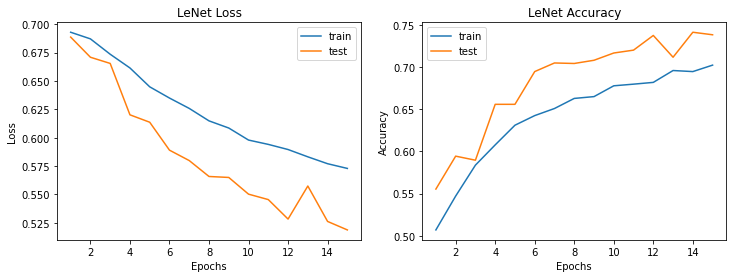

In [99]:
import matplotlib.pyplot as plt

def plot_curve(train_loss, train_acc, test_loss, test_acc, title):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train')
    plt.plot(epochs, test_loss, label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('{} Loss'.format(title))
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='train')
    plt.plot(epochs, test_acc, label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('{} Accuracy'.format(title))
    plt.legend()

    plt.show()

plot_curve(train_loss_vit, train_acc_vit, test_loss_vit, test_acc_vit, 'Vit')

plot_curve(train_loss_lenet, train_acc_lenet, test_loss_lenet, test_acc_lenet, 'LeNet')

In [100]:
weights = torch.load('./target/vit/14.pt')
vit.load_state_dict(weights)
print(vit)
weights = torch.load('./target/lenet/14.pt')
lenet.load_state_dict(weights)
print(lenet)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForwar

infer

In [101]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms

test_dir = r'./data/test/'
test_list = os.listdir(test_dir)
for i in range(len(test_list)):
    test_list[i] = os.path.join(test_dir, test_list[i])

In [102]:
test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [103]:
def infer_lenet(img_path):
    test_transforms = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]
    )
    img = Image.open(img_path)
    img_tensor = test_transforms(img)
    img_tensor = img_tensor.to(device)
    result = lenet(img_tensor)
    class_label = torch.argmax(result)
    class_name = 'cat' if class_label == 0 else 'dog'
    return class_name
    

In [104]:
def infer_vit(img_dir):    
    from einops import rearrange
    img = Image.open(img_dir)
    img_tensor = test_transforms(img)
    img_tensor = img_tensor.to(device)
    img_tensor = rearrange(img_tensor, 'c h w -> 1 c h w')
    result = vit(img_tensor)
    class_label = torch.argmax(result)
    class_name = 'cat' if class_label == 0 else 'dog'
    return class_name


In [105]:
random_idx = np.random.randint(1, len(test_list))
img_dir = test_list[random_idx]
print(infer_lenet(img_dir))
print(infer_vit(img_dir))

cat
dog


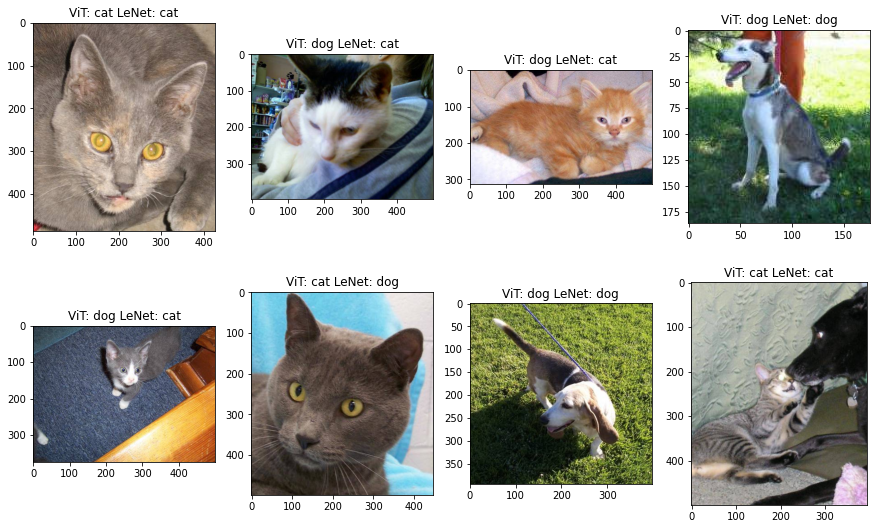

In [106]:
random_idx = np.random.randint(1, len(test_list), size=8)
fig, axes = plt.subplots(2, 4, figsize=(15, 9))

for idx, ax in zip(random_idx, axes.ravel()):
    img = Image.open(test_list[idx])
    label_vit = infer_vit(test_list[idx])
    label_lenet = infer_lenet(test_list[idx])
    label = 'ViT: ' + label_vit + ' LeNet: ' + label_lenet
    ax.set_title(label) 
    ax.imshow(img)